7/19/2021

Need to slightly change the way we're getting the "median" CIV distance in each Gamma bin for the first step.

In [22]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

In [18]:
#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None, label=""):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label=label) #label only once

In [3]:
!ls

AllXRayData.071221.fits
AllXRayData.fits
CIVDistBokehGTR.070521.html
CIVDistBokehGTR.html
CIVDistBokehGTR_logCIVEW.html
CIVDistsBokehGTR.070521.ipynb
CIVDistsBokehGTR_trevor.ipynb
CIV_amy_scaled_linear.npy
CIV_amy_scaled_log.npy
gamma_daox_diagonal_corrs-Copy1.ipynb
gamma_daox_diagonal_corrs.ipynb
gamma_daox_diagonal_corrs_shiftdaox.ipynb
gamma_daox_diagonal_corrs_shiftdaox_2.ipynb
gamma_daox_diagonal_corrs_shiftdaox_3.ipynb
gamma_vs_daox
masking_1.ipynb


In [4]:
df = Table.read('AllXRayData.071221.fits', format='fits')
dat = df.to_pandas()
dat.head()

,SDSS,LOGEDD_RATIO,Gamma,f2keV_ergs,L2500,Alpha_ox,Delta_Alpha_ox,New_Delta_Alpha_ox,Delg-i,Timlin_CIV_EQW,...,Old_redshift,Redshifts,HeII_EQW,LOGBH,Data_source,Clean,RA,DEC,Nardini_Sample,EV1
0,b'SDSSJ123003.80+162308.2',-0.76,1.85810,-31.759840,31.096001,-1.617769,-0.002665,-0.039064,0.116000,NaN,...,NaN,2.37464,0.393129,9.72,4,False,187.515859,16.385636,False,NaN
1,b'150313.62+575151.5 ',-0.42,2.20000,-30.648514,31.443727,-1.622615,0.061687,0.022610,-0.071669,NaN,...,1.721368,NaN,NaN,9.59,1,False,225.806747,57.864326,False,NaN
2,b'SDSSJ092513.03+363748.5',NaN,2.13456,-32.024640,30.580400,-1.456527,0.055972,0.023543,0.042000,NaN,...,NaN,2.77289,2.818198,NaN,4,False,141.304324,36.630149,False,NaN
3,b'SDSSJ135320.48+400809.8',-0.66,2.89310,-31.597590,30.796700,-1.584457,-0.028914,-0.063009,-0.095000,NaN,...,NaN,1.67258,0.651358,9.13,4,False,208.335375,40.136058,False,NaN
4,b'103151.76-013557.2 ',NaN,1.60000,-31.154761,30.838674,-1.499198,0.064698,0.030281,-0.141138,NaN,...,2.295000,2.29601,3.535803,NaN,1,False,157.965674,-1.599229,False,NaN


In [5]:
dat.shape, dat["Clean"].values.sum()

((5682, 23), 1378)

In [6]:
#Take the clean objects that have available measurements
blue = dat["CIV_blue"].values
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
clean = dat["Clean"].values
dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)&clean]

In [7]:
dat.shape

(1067, 23)

In [8]:
#Define vars in cut dataframe
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
blue = dat["CIV_blue"].values
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
c4data = np.array([blue, logEW]).T
c4fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")
CIVdist = CIV_distance(c4data, c4fit, step=1, path="/Users/Trevor1/Desktop/git/CIV_Distance/")

In [9]:
np.isnan(daox).sum()

0

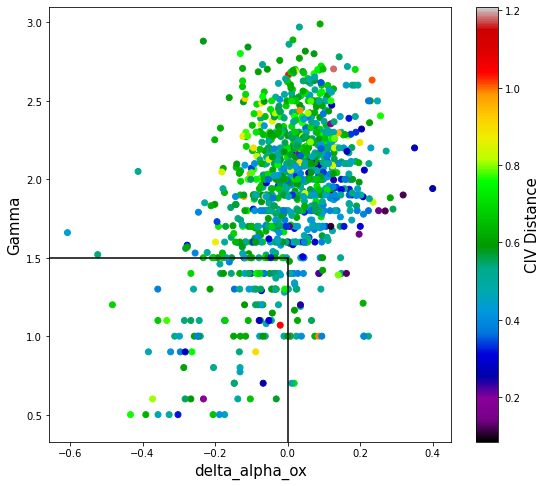

In [10]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

We don't know the absorption track for each individual object.  Instead we'll compute the median value of CIV Distance in bins of $\Gamma$.  

This time, the "median CIV" will be the mode of a Gaussian fit to CIV distance in each Gamma bin.

In [12]:
#Function to return the index of the median - analagous to np.argmin
def argmedian(data, TOL):
    return np.argsort(data)[((len(data)//2)-TOL):((len(data)//2)+TOL)]

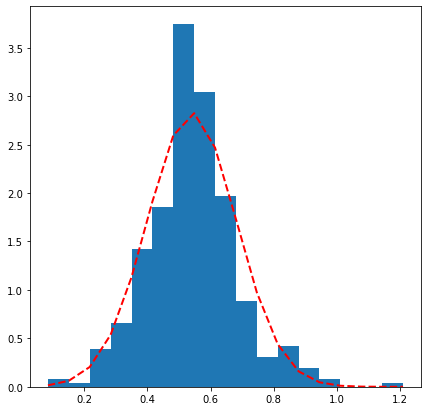

In [60]:
#Work inside particular Gamma bin
test_gamma = (gamma>1.8)&(gamma<2.2)

fig = plt.figure(figsize=(7,7))
(mu, sigma) = norm.fit(CIVdist[test_gamma])
n, bins, patches = plt.hist(CIVdist[test_gamma], bins="scott", density=True)

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

plt.show()

In [62]:
mu, np.mean(CIVdist[test_gamma])

(0.5403273211237595, 0.5403273211237595)

No handles with labels found to put in legend.


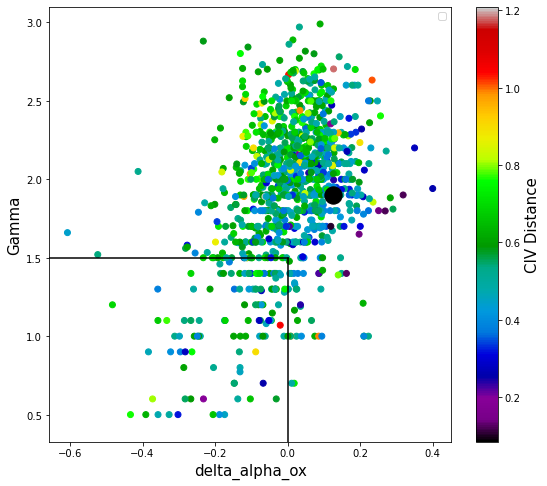

In [27]:
#Where does the mean lie in Gamma vs. daox?
ind_mean = (CIVdist[test_gamma]-mu).argmin()

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
#plt.plot(daox_median_civdist, gamma_bins_plot, "--o", color="k", label="~Median CIV Distance")
plt.scatter(daox[test_gamma][ind_mean], gamma[test_gamma][ind_mean], s=300, c="k")
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

In [15]:
gamma_bins

array([0.5       , 0.76666667, 1.03333333, 1.3       , 1.56666667,
       1.83333333, 2.1       , 2.36666667, 2.63333333, 2.9       ])

In [69]:
def get_mode(n, bins):
    ind = n.argmax()
    return (bins[ind]+bins[ind+1])/2.

In [138]:
%%capture

gamma_bins  = np.linspace(min(gamma), 2.9, 10)
daox_mean_civdist = []
daox_mode_civdist = []
daox_median_civdist = []

for i in range(len(gamma_bins)-1):
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))
    print("Gamma bin %d has %d sources in it" % ((i+1), ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1])).sum()))
    (mu, sigma) = norm.fit(CIVdist[binmask])
    n, bins, patches = plt.hist(CIVdist[binmask], bins="scott", density=True)
    
    ind_mean_civdist = np.abs(CIVdist[binmask]-mu).argmin() #= argmedian(CIVdist[binmask], TOL)
    daox_mean_civdist.append( daox[binmask][ind_mean_civdist] )

    mode = get_mode(n,bins)
    ind_mode = np.abs(CIVdist[binmask]-mode).argmin()
    daox_mode_civdist.append( daox[binmask][ind_mode] )
    
    ind_median = np.abs(CIVdist[binmask]-np.median(CIVdist[binmask])).argmin()
    daox_median_civdist.append(daox[binmask][ind_median])
    
gamma_bins_plot = gamma_bins[:-1] + ((gamma_bins[1]-gamma_bins[0])/2)

In [139]:
mu, mode

(0.6518809156867956, 0.5615717455377428)

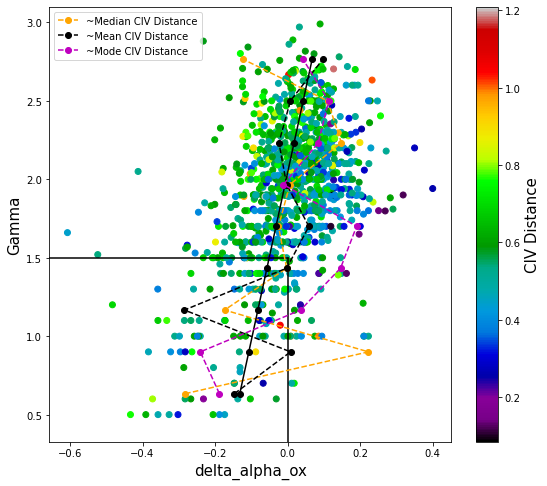

In [172]:
m_mean, b_mean = np.polyfit(gamma_bins_plot, daox_mean_civdist, 1)
x_mean_range = gamma_bins_plot.copy()
y_mean = m_mean*x_mean_range + b_mean
fit_meanciv = np.array([y_mean, x_mean_range]).T

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(daox_median_civdist, gamma_bins_plot, "--o", color="orange", label="~Median CIV Distance")
plt.plot(daox_mean_civdist, gamma_bins_plot, "--o", color="k", label="~Mean CIV Distance")
plt.plot(fit_meanciv[:,0], fit_meanciv[:,1], "-o", color="k") #, label="~Mean CIV Distance")
plt.plot(daox_mode_civdist, gamma_bins_plot, "--o", color="m", label="~Mode CIV Distance")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

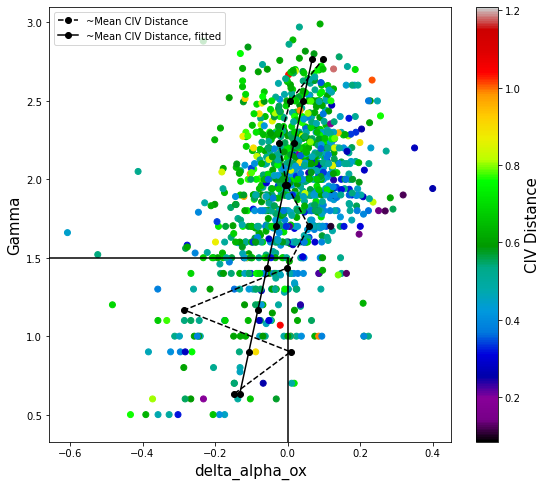

In [174]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(daox_mean_civdist, gamma_bins_plot, "--o", color="k", label="~Mean CIV Distance")
plt.plot(fit_meanciv[:,0], fit_meanciv[:,1], "-o", color="k", label="~Mean CIV Distance, fitted")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

The problem with just taking the point where the median CIV distance is that it may happen to be an outlier in $\Delta\alpha_\mathrm{ox}$ and hence not really track where the "center" of CIV distance is in each Gamma bin.

Instead, in the above I take the mean $\Delta\alpha_\mathrm{ox}$ of the ``2*TOL`` CIV distances closest to the median, which roughly tracks where the "central" CIV distance is in each Gamma bin.

Now, change each $\Delta\alpha_\mathrm{ox}$ in each Gamma bin so that the medians of the bins align at ~0.

Want to loop through each data point

1) Check which gamma it's closest to in the plot; save index

2) Save $\Delta\alpha_{ox}$ corresponding to the given gamma (based on the median)

3) Shift $\Delta\alpha_{ox}$ for that object by minus that much

In [183]:
#daox_ref = daox_median_civdist[np.abs(daox_median_civdist).argmin()] #Save civdist closest to alphaox=0
#daox_ref = daox_mode_civdist[np.abs(daox_mode_civdist).argmin()]
#daox_ref = daox_mean_civdist[np.abs(daox_mean_civdist).argmin()]
daox_ref = fit_meanciv[np.abs(fit_meanciv[:,0]).argmin(),0]

daox_new = []
for i in range(len(gamma)):
    ind = abs(gamma[i]-gamma_bins_plot).argmin()
    gamma_close = gamma_bins_plot[ind]
    #daox_close = daox_median_civdist[ind]
    #daox_close = daox_mode_civdist[ind]
    #daox_close = daox_mean_civdist[ind]
    daox_close = fit_meanciv[ind,0]
    daox_new.append(daox[i]-daox_close+daox_ref)
daox_new = np.array(daox_new)

In [184]:
fit_meanciv[:,1]

array([0.63333333, 0.9       , 1.16666667, 1.43333333, 1.7       ,
       1.96666667, 2.23333333, 2.5       , 2.76666667])

In [185]:
daox_ref

-0.007028201723548261

In [219]:
%%capture
#Recompute median daox
mean_daox_new = []
mode_daox_new = []
median_daox_new = []
for i in range(len(gamma_bins)-1):
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))
    
    (mu, sigma) = norm.fit(CIVdist[binmask])
    n, bins, patches = plt.hist(CIVdist[binmask], bins="scott", density=True)
    ind_mean_civdist = np.abs(CIVdist[binmask]-mu).argmin() #= argmedian(CIVdist[binmask], TOL)
    mean_daox_new.append( daox_new[binmask][ind_mean_civdist] )
    
    mode = get_mode(n,bins)
    ind_mode = np.abs(CIVdist[binmask]-mode).argmin()
    mode_daox_new.append( daox_new[binmask][ind_mode] )
    
    ind_median = np.abs(CIVdist[binmask]-np.median(CIVdist[binmask])).argmin()
    median_daox_new.append(daox_new[binmask][ind_median])

In [220]:
mean_daox_new

[-0.02191380346332658,
 0.10805269786856975,
 -0.20964589769099592,
 0.04738070627433936,
 0.08370332479663467,
 -0.00264641726734,
 -0.04889816928133672,
 -0.042179573468678455,
 0.02289331672019962]

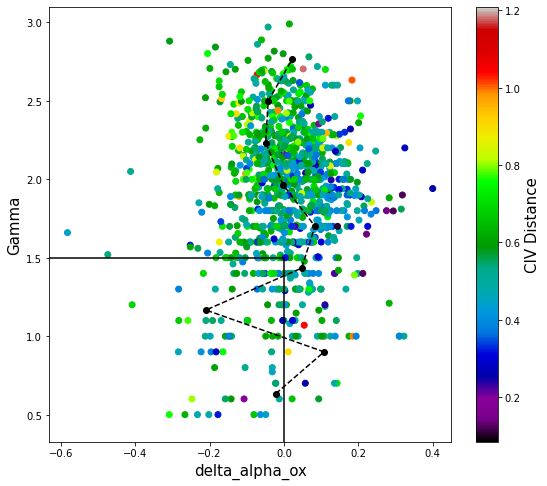

In [221]:
#m,b = np.polyfit(median_daox_new[2:], gamma_bins_plot[2:], 1)
#x = np.linspace(-0.6, 0.45, 10000)
#y = m*x + b

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_new, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(mean_daox_new, gamma_bins_plot, "--o", color="k")
#plt.plot(mode_daox_new, gamma_bins_plot, "--o", color="k")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

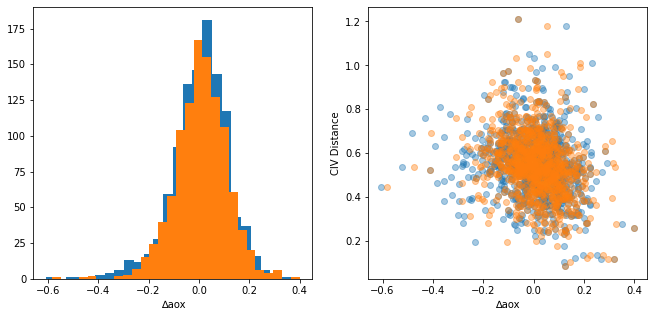

In [222]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Median-gamma shifted ∆aox")
ax1.set_xlabel("∆aox")

ax2.scatter(daox, CIVdist, alpha=0.4, label="Original ∆aox")
ax2.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
ax2.set_xlabel("∆aox")
ax2.set_ylabel("CIV Distance")

plt.show()

Reduced the spread, so just look at the new distribution,

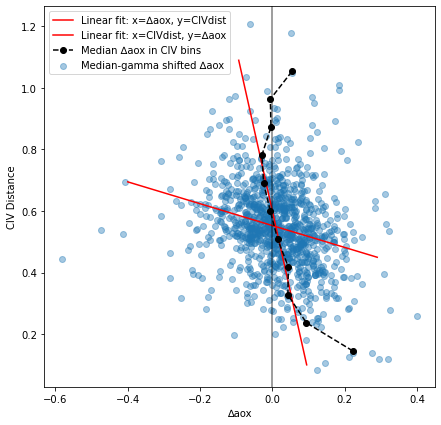

In [223]:
#See what a simple linear fit looks like - do two versions, flipping the axes
m1,b1 = np.polyfit(daox_new, CIVdist, 1)
x1 = np.arange(-0.4, 0.3, 0.01)
y1 = m1*x1 + b1
fit_lin1 = np.array([x1,y1]).T

m2,b2 = np.polyfit(CIVdist, daox_new, 1)
x2 = np.arange(0.1, 1.1, 0.01)
y2 = m2*x2 + b2
fit_lin2 = np.array([y2,x2]).T

#Also get the median ∆aox in each CIV bin
CIVdist_bins  = np.linspace(0.1, 1.1, 12)
median_daox_new_civ = []
for i in range(len(CIVdist_bins)-1):
    daox_new_med = np.median(daox_new[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    median_daox_new_civ.append(daox_new_med)
CIVdist_bins_plot = CIVdist_bins[:-1] + ((CIVdist_bins[1]-CIVdist_bins[0])/2)



fig, ax1 = plt.subplots(figsize=(7,7))

ax1.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
#plot_contour(daox_new, CIVdist, c="b", label="Median-gamma shifted ∆aox")
ax1.plot(fit_lin1[:,0], fit_lin1[:,1], "-r", label="Linear fit: x=∆aox, y=CIVdist")
ax1.plot(fit_lin2[:,0], fit_lin2[:,1], "-r", label="Linear fit: x=CIVdist, y=∆aox")
ax1.plot(median_daox_new_civ, CIVdist_bins_plot, "--o", c="k", label="Median ∆aox in CIV bins")

xlims, ylims = ax1.get_xlim(), ax1.get_ylim()
ax1.plot([0.0,0.0], [0.0,1.4], "-k", alpha=0.5)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.set_xlabel("∆aox")
ax1.set_ylabel("CIV Distance")
ax1.legend(loc="best")

plt.show()

Check new $\alpha_\mathrm{ox}$ vs. L2500

$$ \alpha_{ox,fit} = \alpha_{ox} - \Delta\alpha_{ox} $$

So the new $\alpha_{ox}$ value is 

$$ \alpha_{ox,new} = \alpha_{ox,old} - (\Delta\alpha_{ox,old} - \Delta\alpha_{ox,new}) $$

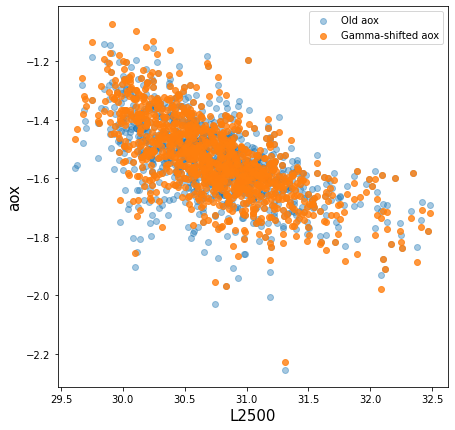

In [224]:
aox           = dat["Alpha_ox"].values #original aox values
aox_gamma     = aox - (daox - daox_new) #aox shifted based on gamma bins
L2500 = dat["L2500"].values

fig = plt.figure(figsize=(7,7))
plt.scatter(L2500, aox, alpha=0.4, label="Old aox")
plt.scatter(L2500, aox_gamma, alpha=0.8, label="Gamma-shifted aox")
plt.ylabel("aox", fontsize=15)
plt.xlabel("L2500", fontsize=15)
plt.legend(loc="best")
plt.show()

---

Now want to shift individual points in each gamma bin based on their CIV distance.

Fit a line to the newly shifted Gamma vs. daox data

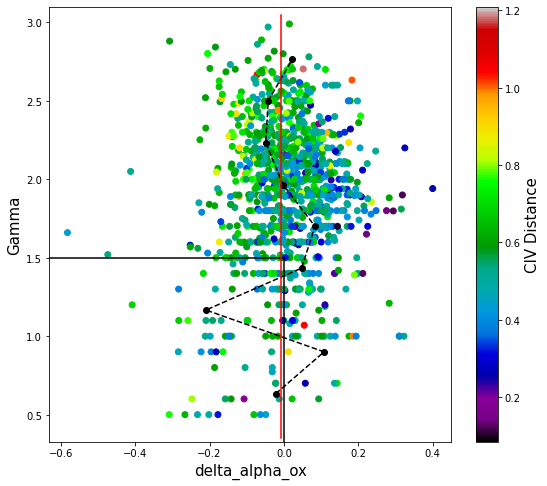

In [225]:
m_gamma, b_gamma = np.polyfit(gamma_bins_plot, mean_daox_new, 1)
x_gamma = np.linspace(0.35,3.05,1000)
y_gamma = m_gamma*x_gamma + b_gamma
fit_gamma = np.array([y_gamma,x_gamma]).T

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_new, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(mean_daox_new, gamma_bins_plot, "--o", color="k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

In [226]:
m_gamma

-5.435477951307975e-17

We now need a fit of CIV distance vs distance from the red line above.  Then, based on each object's CIV distance, we'll shift it a given amount towards the red line.


1) Scale the data (so as to shift orthogonally towards the red line)

Looping through each data point above:

2) Get the distance from the red line


In [227]:
def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get distance^2 of point from line - minimum
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with magnitude) of each point from the line
        
    disty = []
    distx = []
    abs_disty = []
    abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 )
        r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        ind_yax = r_y.argmin()
        ind_xax = r_x.argmin()
        abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on so we can have negative distances
        proj_x = project_pt(data[i,:], xax)
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

In [228]:
def argmedian1(data):
    return np.argsort(data)[len(data)//2]

In [229]:
yax = fit_gamma.copy()
indmed = argmedian1(yax[:,1]) #get index where gamma is median - just for visual purposes
data_gamma = np.array([daox_new, gamma]).T

#Create and fit the scaler
scaler_gamma = MinMaxScaler().fit(data_gamma[data_gamma[:,1]<3.1]) #Max out scaler at 3.1
data_gamma_scale = scaler_gamma.transform(data_gamma)
yax_scale = scaler_gamma.transform(yax)

#Create a perpendicular axis in the scaled space
x_perp_scale = np.linspace(-.05, 1.05, 500)
m_gamma_perp_scale = -1 / lin_slope(yax_scale)
xi, yi = yax_scale[indmed,:]
b_gamma_perp_scale = yi - m_gamma_perp_scale*xi
xax_scale = np.array( [ x_perp_scale, m_gamma_perp_scale*x_perp_scale + b_gamma_perp_scale ] ).T

<ipython-input-227-44f21d27d75a>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])


In [230]:
yax_scale[indmed,:]

array([0.58545095, 0.48247042])

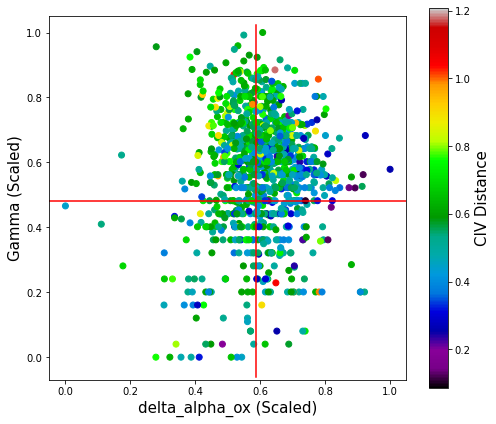

In [231]:
fig = plt.figure(figsize=(8,7))
plt.scatter(data_gamma_scale[:,0], data_gamma_scale[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
#plt.plot([xlims[0],0],[1.5,1.5], "-k")
#plt.plot([0,0],[ylims[0],1.5], "-k")
#plt.plot(median_daox_new, gamma_bins_plot, "--o", color="k")
plt.plot(yax_scale[:,0], yax_scale[:,1], "-r")
plt.plot(xax_scale[:,0], xax_scale[:,1], "-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],1.05)
plt.xlim(xlims)
plt.ylabel("Gamma (Scaled)", fontsize=15)
plt.xlabel("delta_alpha_ox (Scaled)", fontsize=15)
plt.gca().set_aspect("equal")
plt.show()

Now that we have new x- and y-axes, we can determine distances from the scaled y-axis.  Note that the x-axis is just to determine which side of the y-axis each point is on.

The distance is:

$$ r_i = \min{ \sqrt{ ({\bf x_\mathrm{line}} - x_i)^2 + ({\bf y_\mathrm{line}} - y_i)^2 } } $$

By using the new x-axis as well, we can also project the point onto it -- then, if its x-value on the new x-axis is higher than the x-value of the point where the lines intersect, it is positive distance from the line.  Negative distance in the opposite scenario.

Get the distances from the new y-axis and plot against CIV distance; it looks like there should be a correlation.

In [232]:
dist_yax_scaled = perp_distance(data_gamma_scale, xax_scale, yax_scale)

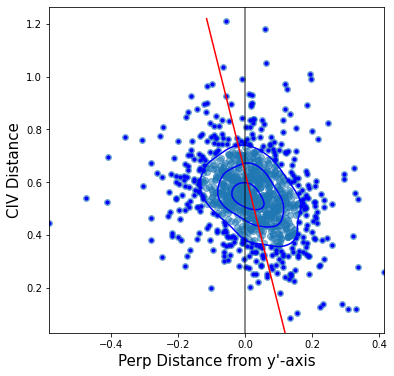

In [233]:
m_civ,b_civ = np.polyfit(CIVdist, dist_yax_scaled, 1)
yrange_civ = np.linspace(0.02,1.22,500)
x_civ = m_civ*yrange_civ + b_civ

fig = plt.figure(figsize=(6,6))
plt.scatter(dist_yax_scaled, CIVdist, alpha=0.5)
ylims = plt.gca().get_ylim()
plot_contour(dist_yax_scaled, CIVdist, c="b")
plt.plot(x_civ, yrange_civ, "-r")
plt.plot([0,0],[-0.1,1.5],"-k", alpha=0.6)
plt.ylabel("CIV Distance", fontsize=15)
plt.xlabel("Perp Distance from y'-axis", fontsize=15)
plt.ylim(ylims)
plt.show()

In [234]:
m_civ,b_civ

(-0.19674131797196093, 0.12463994800867995)

Now, given a point's CIV distance, what do we expect the perpendicular distance from the y'-axis to be?  This is the distance towards zero we'll shift that point.

And the unit vector pointing along the orthogonal projection of the the point onto the curve gives the direction to shift:

$$ \hat{\bf r}_i = \frac{( x_\mathrm{line,min} - x_i, y_\mathrm{line,min} - y_i )}{r_i} $$

So if the original position of the data is ${\bf x}$, then its position along the new y axis ${\bf x}'$ is given by:

$$ {\bf x}' = {\bf x} + r_i\hat{\bf r}_i $$

In this, we'll fit for $r_i$ as a function of CIV distance.

In [235]:
def diag_shift(data, line, mag_shift):
    data_proj = project_pt(data, line)
    rvec = np.array((data_proj[0]-data[0], data_proj[1]-data[1]))
    rmag = np.linalg.norm(rvec)
    rhat = rvec / rmag
    return data + mag_shift*rhat

In [236]:
data_gamma_civ_scale = []
for i in range(len(CIVdist)):
    #Get index of the fitted CIV distance of point
    indperp = abs(CIVdist[i]-yrange_civ).argmin()
    perpshift = x_civ[indperp]
    data_shifted = diag_shift(data_gamma_scale[i,:], yax_scale, abs(perpshift))
    data_gamma_civ_scale.append(data_shifted)
data_gamma_civ_scale = np.array(data_gamma_civ_scale)

In [237]:
#Now inverse transform back into unscaled Gamma vs. ∆aox space
data_gamma_civ = scaler_gamma.inverse_transform(data_gamma_civ_scale)

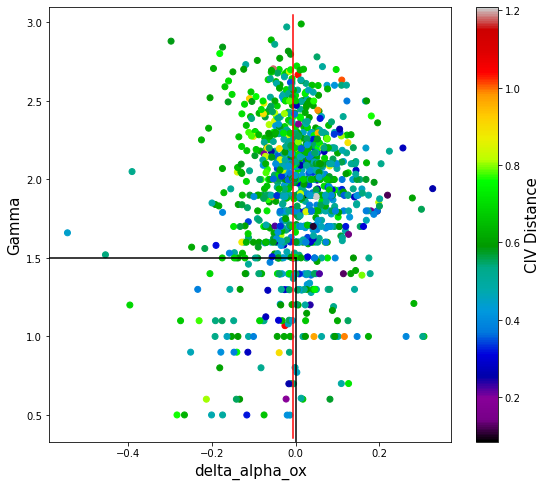

In [238]:
fig = plt.figure(figsize=(9,8))
plt.scatter(data_gamma_civ[:,0], data_gamma_civ[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

The color gradient is not as strong anymore, so it looks like it worked.  Now check again the spread in $\Delta\alpha_\mathrm{ox}$ and L2500 vs. $\alpha_\mathrm{ox}$ to see if spread decreased

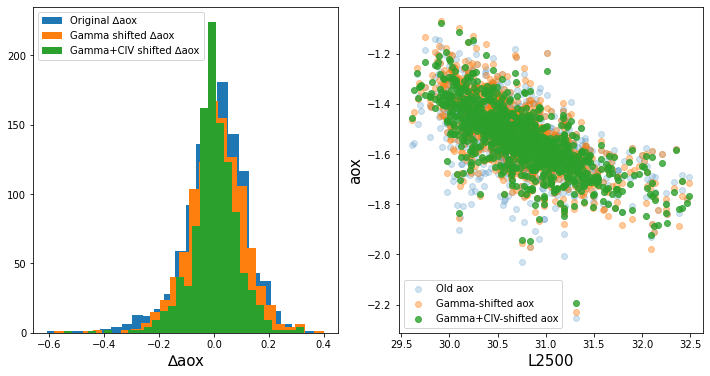

In [239]:
aox_gamma_civ = aox - (daox - data_gamma_civ[:,0]) #aox shifted based on gamma bins

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Gamma shifted ∆aox")
ax1.hist(data_gamma_civ[:,0], bins="scott", label="Gamma+CIV shifted ∆aox")
ax1.set_xlabel("∆aox", fontsize=15)
ax1.legend(loc="best")

ax2.scatter(L2500, aox, alpha=0.2, label="Old aox")
ax2.scatter(L2500, aox_gamma, alpha=0.4, label="Gamma-shifted aox")
ax2.scatter(L2500, aox_gamma_civ, alpha=0.8, label="Gamma+CIV-shifted aox")
ax2.set_ylabel("aox", fontsize=15)
ax2.set_xlabel("L2500", fontsize=15)
ax2.legend(loc="best")

plt.show()

Good -- this seems to have worked.

----

In [71]:
plt.savefig?